# ETF Price Prediction
- Dataset: 
    - A stock price and volume dataset for the ETF with the ticker symbol "CERN"
    - [Kaggle Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data)

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

from scipy.signal import periodogram
# Applying Fourier transformation for capturing seasonality
from scipy.fft import fft

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# ETF: CERN
data = pd.read_csv('../../data/common/etf-cern.us.txt', sep=',', parse_dates=[0])
data.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
3196,2017-11-06,65.36,65.810,65.06,65.71,1359851,0
3197,2017-11-07,65.78,66.240,65.67,65.93,1404928,0
3198,2017-11-08,65.85,66.470,65.60,66.28,1331746,0
3199,2017-11-09,65.87,66.105,64.69,65.48,1491859,0
3200,2017-11-10,65.31,65.560,64.93,65.31,1327855,0


In [3]:
# crop the time period to the start of 2010 onwards
df = data[data["Date"].dt.year >=2010].copy() \
        .reset_index(drop=True) # reset the index

## EDA
- OHLC (Open/High/Low/Close) Chart

In [4]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(
    go.Ohlc(
        x=df["Date"],
        open=df["Open"],
        high=df["High"],
        low=df["Low"],
        close=df["Close"],
        name="Price"
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=df["Date"],
        y=df["Volume"],
        name="Volume"
    ),
    row=2, col=1
)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [5]:
df_close = df[["Date", "Close"]].copy()
df_close = df_close.set_index("Date")

In [6]:
# Calculate the periodogram
frequencies, spectrum = periodogram(df_close["Close"])
# Identify the dominant frequencies (top 3)
top_k = 10
dominant_frequencies = frequencies[spectrum.argsort()[-top_k:][::-1]]
seasonal_period = 1 / dominant_frequencies
# print(f"Dominant frequency: {dominant_frequencies}")
print(f"Potential Seasonal's periods (m): {list(seasonal_period)} ")

Potential Seasonal's periods (m): [1978.9999999999998, 494.74999999999994, 659.6666666666665, 989.4999999999999, 329.83333333333326, 282.71428571428567, 219.88888888888889, 247.37499999999997, 395.8, 152.2307692307692] 


- The potential periods are close to 365 days, so we will select `period=365` in the time series decompose

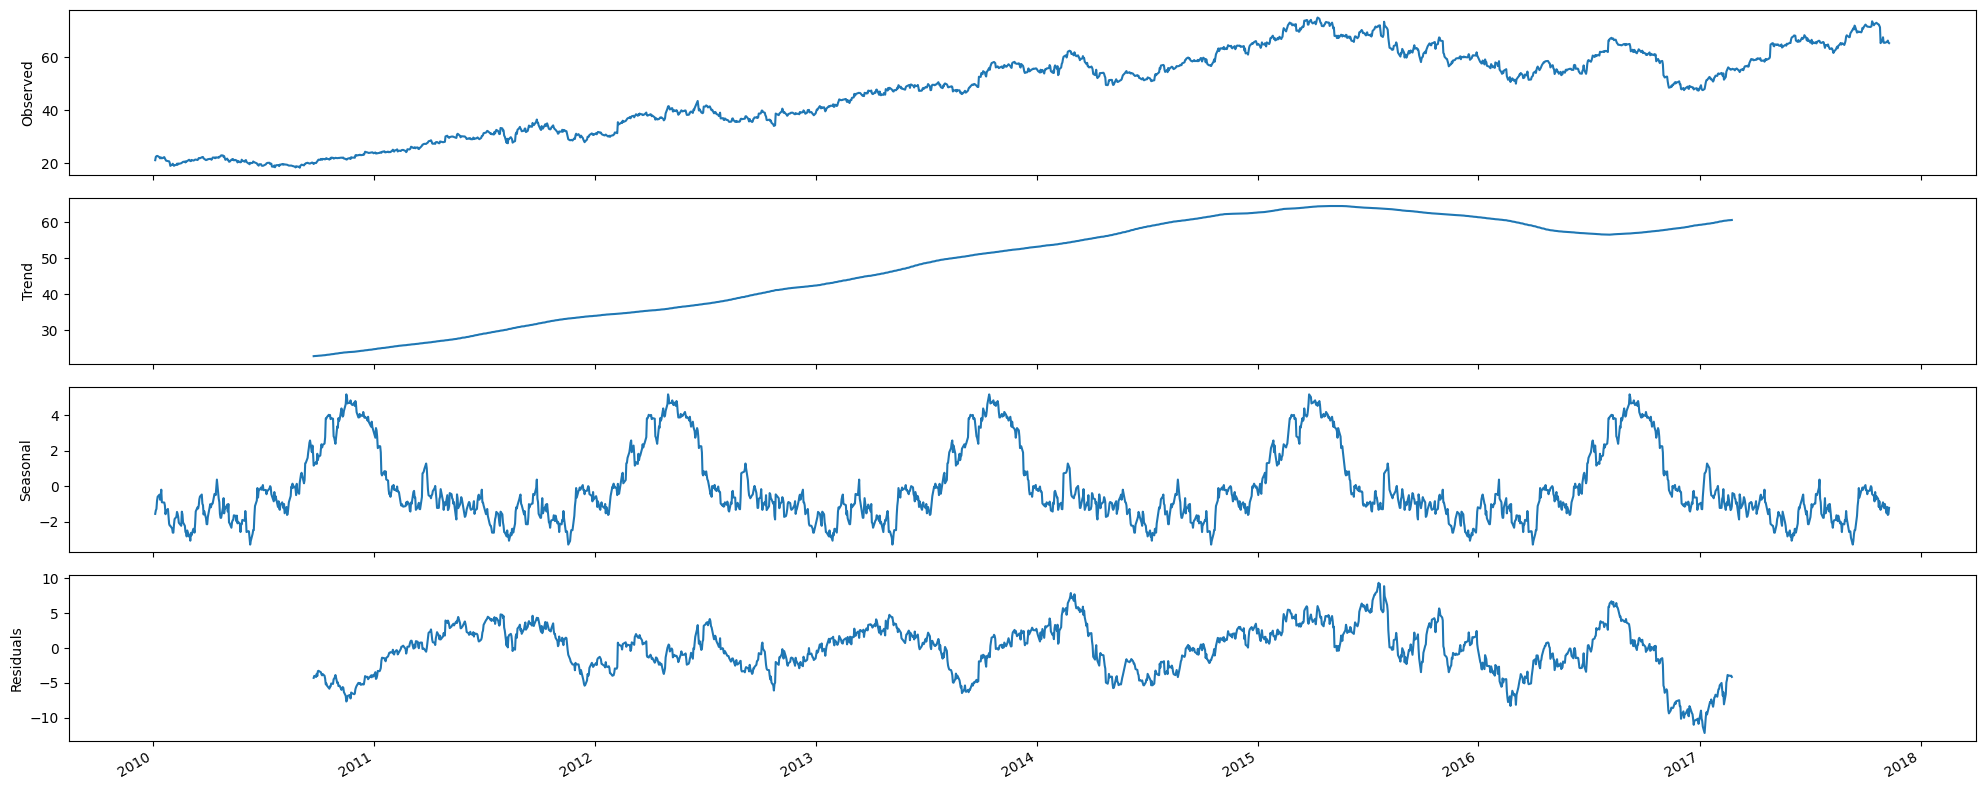

In [7]:
# Decompose the series using the STL function. 
# The period is equal to the frequency m. Since we have monthly data, the period is 12.
def decompose_ts(df, model='additive', period=12):
    decomposition = seasonal_decompose(df, model=model, period=period)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20,8))

    ax1.plot(decomposition.observed)
    ax1.set_ylabel('Observed')

    ax2.plot(decomposition.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(decomposition.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.plot(decomposition.resid)
    ax4.set_ylabel('Residuals')

    fig.autofmt_xdate()
    plt.tight_layout()

decompose_ts(df_close["Close"], period=365)

- There are a seasonal patterns for around 2 years per each cycle

In [40]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [41]:
check_stationarity(df["Close"])

ADF Statistic : -1.38581, p-value: 0.58906
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
KPSS Statistic: 5.93488, p-value: 0.01000
Non-stationary


In [42]:
df_close_diff = np.diff(df["Close"], n=1)
check_stationarity(df_close_diff)

ADF Statistic : -45.65103, p-value: 0.00000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
KPSS Statistic: 0.06586, p-value: 0.10000
Stationary


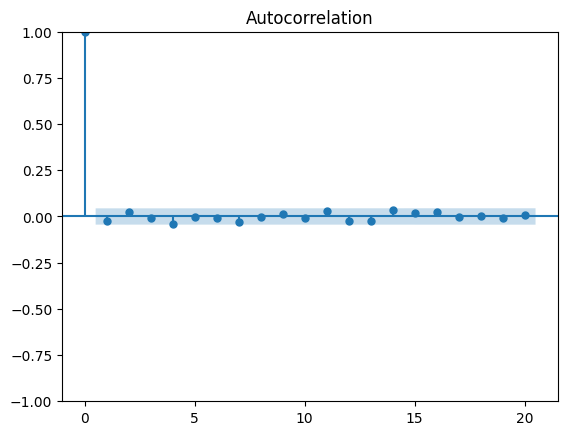

In [44]:
plot_acf(df_close_diff, lags=20);

- From the ACF above plot, there are no significant coefficients after lag 0. This is a clear indicator that we are dealing with a random walk as the first difference of the series is stationary & it is also not correlated.
- In this case, the best method to model the random walk is to use naive methods such as taking the last value to predict for today's one. However, for demo purpose, we will continue to demonstate on how to use XGBoost to model the time series

In [8]:
df = df.drop(columns=["Open", "High", "Low", "Volume","OpenInt"])

## Feature Engineering

In [9]:
class FePipeline:
    def __init__(self, 
                 target_column: str,
                 date_column: str,
                 lags: list[int],
                 windows: list[int],
                 rolling_stats: list[str], 
                 ):
        self.target_column = target_column
        self.date_column = date_column
        self.lags = lags
        self.windows = windows
        self.rolling_stats = rolling_stats
    def run_pipeline(self, df):
        ts = df.copy()
        ts = self._create_date_features(ts)
        ts = self._create_lag_feature(ts)
        ts = self._create_rolling_features(ts)
        ts = self._create_rate_of_change_feature(ts)
        ts = self._create_ema_features(ts)
        ts = self._create_macd_features(ts)
        ts = self._create_rsi_feature(ts, window=5)
        ts = self._create_fourier_transform(ts)
        return ts

    def _create_date_features(self, ts):
        if not pd.api.types.is_datetime64_any_dtype(ts[self.date_column]):
            df.loc[:, self.date_column] = pd.to_datetime(df[self.date_column])
        
        ts['day_of_week'] = ts[self.date_column].dt.dayofweek
        ts['is_weekend'] = (ts[self.date_column].dt.dayofweek >= 5).astype(int)
        ts['day'] = ts[self.date_column].dt.day
        ts['month'] = ts[self.date_column].dt.month
        ts['quarter'] = ts[self.date_column].dt.quarter
        ts['year'] = ts[self.date_column].dt.year
        ts['day_of_year'] = ts[self.date_column].dt.dayofyear
        #ts['week_of_year'] = ts[self.date_column].dt.weekofyear
        # sine-cosine features: capturing cyclical patterns such as daily, weekly, or yearly cycles.
        ts['sin_dayofweek'] = np.sin(2 * np.pi * ts[self.date_column].dt.dayofweek / 7)
        ts['cos_dayofweek'] = np.cos(2 * np.pi * ts[self.date_column].dt.dayofweek / 7)
        ts['ismonthstart'] = ts[self.date_column].dt.is_month_start.astype(int)
        ts['ismonthend'] = ts[self.date_column].dt.is_month_end.astype(int)
        ts['isquarterstart'] = ts[self.date_column].dt.is_quarter_start.astype(int)
        ts['isquarterend'] = ts[self.date_column].dt.is_quarter_end.astype(int)
        ts['isyearstart'] = ts[self.date_column].dt.is_year_start.astype(int)
        ts['isyearend'] = ts[self.date_column].dt.is_year_end.astype(int)
        ts['isleapyear'] = ts[self.date_column].dt.is_leap_year.astype(int)
        
        return ts
    def _create_lag_feature(self, ts):
        for lag in self.lags:
            ts[f"lag_{lag}"] = ts[self.target_column].shift(lag)
        return ts
    def _create_rolling_features(self, ts):
        for stat in self.rolling_stats:
            for window in self.windows:
                if stat == "mean":
                    ts[f"rolling_mean_{window}"] = ts[self.target_column].rolling(window=window).mean()
                if stat == "std":
                    ts[f"rolling_mean_{window}"] = ts[self.target_column].rolling(window=window).ts()
        return ts
    def _create_rate_of_change_feature(self, ts):
        for n in self.lags:
            ts[f"roc_period={n}"] = ts[self.target_column].pct_change(periods=n) # try 1 and 5
        return ts
    def _create_ema_features(self, ts):
        for window in self.windows:
            ts[f"ema_{window}"] = ts[self.target_column].ewm(span=window, adjust=False).mean()
        return ts
    def _create_macd_features(self, ts):
        EMA_12 = pd.Series(ts[self.target_column].ewm(span=12, min_periods=12).mean())
        EMA_26 = pd.Series(ts[self.target_column].ewm(span=26, min_periods=26).mean())
        ts['MACD'] = pd.Series(EMA_12 - EMA_26)
        ts['MACD_signal'] = pd.Series(ts.MACD.ewm(span=9, min_periods=9).mean())
        return ts
    def _create_rsi_feature(self, ts, window):
        # Calculate price changes
        delta = ts[self.target_column].diff()

        # Separate gains and losses
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

        # Calculate Relative Strength (RS)
        rs = gain / loss

        # Calculate RSI
        ts["rsi"] = 100 - (100 / (1 + rs))
        return ts
    def _create_fourier_transform(self, ts):
        values = ts[self.target_column].values
        fourier_transform = fft(values)
        ts['fourier_transform'] = np.abs(fourier_transform)
        return ts


In [10]:
fe_pipeline = FePipeline("Close", "Date", 
                         lags=[1,2,3,4,5],
                         windows=[5, 10, 15, 30],
                         rolling_stats=['mean']
)
fe_df = fe_pipeline.run_pipeline(df)

In [11]:
fe_df.tail()

,Date,Close,day_of_week,is_weekend,day,month,quarter,year,day_of_year,sin_dayofweek,...,roc_period=4,roc_period=5,ema_5,ema_10,ema_15,ema_30,MACD,MACD_signal,rsi,fourier_transform
1974,2017-11-06,65.71,0,0,6,11,4,2017,310,0.000000,...,-0.026807,-0.011285,66.097199,67.362304,68.261439,69.202865,-1.338523,-0.553915,39.067055,1840.278634
1975,2017-11-07,65.93,1,0,7,11,4,2017,311,0.781831,...,0.006719,-0.023549,66.041466,67.101885,67.970009,68.991713,-1.386458,-0.720424,19.305019,5910.058394
1976,2017-11-08,66.28,2,0,8,11,4,2017,312,0.974928,...,0.012372,0.012063,66.120977,66.952451,67.758758,68.816764,-1.380294,-0.852398,93.406593,5413.355551
1977,2017-11-09,65.48,3,0,9,11,4,2017,313,0.433884,...,0.000764,0.000153,65.907318,66.684733,67.473913,68.601489,-1.423552,-0.966629,50.295858,4126.761228
1978,2017-11-10,65.31,4,0,10,11,4,2017,314,-0.433884,...,-0.006087,-0.001834,65.708212,66.434781,67.203424,68.389134,-1.454783,-1.064260,46.703297,18628.107996


### Shift label column
- Use X features at a given time (t) to predict the target in the future (t+1)

In [12]:
# This code moves all values up by 1 position
fe_df['Close'] = fe_df['Close'].shift(-1)

In [13]:
fe_df = fe_df.iloc[33:] # because of MACD lines, making the first 33 MACD values are NaN
fe_df = fe_df.iloc[:-1] # because the shifting close price 

In [14]:
fe_df = fe_df.reset_index(drop=True)

In [15]:
fe_df.tail()

,Date,Close,day_of_week,is_weekend,day,month,quarter,year,day_of_year,sin_dayofweek,...,roc_period=4,roc_period=5,ema_5,ema_10,ema_15,ema_30,MACD,MACD_signal,rsi,fourier_transform
1940,2017-11-03,65.71,4,0,3,11,4,2017,307,-0.433884,...,-0.015498,0.001837,66.290798,67.729482,68.625930,69.443753,-1.235470,-0.357763,51.395349,3870.275625
1941,2017-11-06,65.93,0,0,6,11,4,2017,310,0.000000,...,-0.026807,-0.011285,66.097199,67.362304,68.261439,69.202865,-1.338523,-0.553915,39.067055,1840.278634
1942,2017-11-07,66.28,1,0,7,11,4,2017,311,0.781831,...,0.006719,-0.023549,66.041466,67.101885,67.970009,68.991713,-1.386458,-0.720424,19.305019,5910.058394
1943,2017-11-08,65.48,2,0,8,11,4,2017,312,0.974928,...,0.012372,0.012063,66.120977,66.952451,67.758758,68.816764,-1.380294,-0.852398,93.406593,5413.355551
1944,2017-11-09,65.31,3,0,9,11,4,2017,313,0.433884,...,0.000764,0.000153,65.907318,66.684733,67.473913,68.601489,-1.423552,-0.966629,50.295858,4126.761228


## Train Test Split
- Training (70%), Validation (15%), and Test (15%)

In [16]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

In [17]:
X = fe_df.drop(columns=["Close"])
y = fe_df["Close"]

In [18]:
X_train, y_train  = X.iloc[:valid_split_idx].copy(), y.iloc[:valid_split_idx].copy()
X_valid, y_valid  = X.iloc[valid_split_idx+1:test_split_idx].copy(), y.iloc[valid_split_idx+1:test_split_idx].copy()
X_test, y_test  = X.iloc[test_split_idx+1:].copy(), y.iloc[test_split_idx+1:].copy()

In [19]:
X_test_date = X_test['Date']

In [20]:
X_train.shape

(1385, 39)

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_train.Date, y=y_train, name='Training'))
fig.add_trace(go.Scatter(x=X_valid.Date, y=y_valid, name='Validation'))
fig.add_trace(go.Scatter(x=X_test.Date,  y=y_test,  name='Test'))
fig.update_layout(
    yaxis_title='Price ($)',
    xaxis_title='Date',
    title="CERN ETF's Close Price from 2010 to 2017 - Train Test Split"
)  
fig.show()

In [22]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

In [23]:
X_train.drop(columns=["Date"], inplace=True)
X_valid.drop(columns=["Date"], inplace=True)
X_test.drop(columns=["Date"], inplace=True)

In [24]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

In [25]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    eval_set=[(      day_of_week  is_weekend  day  month  quarter  year  day_of_year  \
0               0           0   22      2        1  2010           53   
1               1           0   23      2        1  2010           54   
2               2           0   24      2        1  2010           55   
3               3           0   25      2        1  2010           56   
4               4           0   26      2        1...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0.001, 0.005, 0.01, 0.02],
                         'learning_rate': [0.001, 0.005, 0.01, 0.05],
                         'max_depth': [8, 10, 12, 15],
                         'n_estimators': [100, 200, 300, 400],
                         'random_state': [42]})

In [26]:
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.005, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42}
Best validation score = -2.1974896773306076


In [27]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.005, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

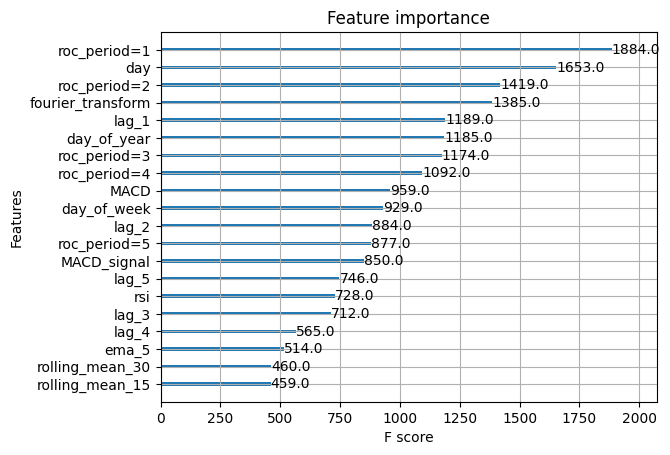

In [36]:
xgb.plot_importance(model, max_num_features=20);

In [29]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [58.4  58.58 57.34 53.15 52.81]
y_pred = [56.502644 57.05223  57.490158 57.56657  54.109802]


In [30]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')


mean_squared_error = 2.5817407333479103


- mean_squared_error = 2.167622478575534

In [ ]:
latest_x_train = pd.concat([X_train, X_valid])
latest_y_train = pd.concat([y_train, y_valid])

In [57]:
def rolling_forecast(latest_x_train, latest_y_train, X_test, y_test, best_params, fixed_window=False):
    prediction = []

    for counter, idx in tqdm(enumerate(range(X_test.index.min(), X_test.index.max()+1))):
        model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
        #print(latest_x_train.shape, latest_y_train.shape)
        model.fit(latest_x_train, latest_y_train, verbose=False)
        pred = model.predict(X_test.loc[idx, : ].values.reshape(1, -1))
        prediction.append(pred[0])

        start_idx = latest_x_train.index.min() + counter if fixed_window else latest_x_train.index.min()
        latest_x_train = pd.concat([latest_x_train[start_idx:], X_test.loc[idx, : ].to_frame().T], ignore_index=True)
        latest_y_train = pd.concat([latest_y_train[start_idx:], pd.Series(y_test.loc[idx]).to_frame().T], ignore_index=True)
    
    return np.array(prediction)

hyper_params = clf.best_params_

# hyper_params = {
#     'gamma': 0.02,
#     'learning_rate': 0.05,
#     'max_depth': 8,
#     'n_estimators': 200,
#     'random_state': 42
# }
y_pred_rolling = rolling_forecast(latest_x_train, latest_y_train, X_test, y_test, hyper_params)


262it [04:18,  1.01it/s]


In [58]:
y_pred_rolling_fixed = rolling_forecast(latest_x_train, latest_y_train, X_test, y_test, hyper_params, True)

262it [01:02,  4.18it/s]


In [63]:
print(f"MAPE - XGB Pred              : {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"MAPE - XGB Pred Rolling      : {mean_absolute_percentage_error(y_test, y_pred_rolling)}")
print(f"MAPE - XGB Pred Rolling Fixed: {mean_absolute_percentage_error(y_test, y_pred_rolling_fixed)}")
print(f"MAPE - Last Value Pred       : {mean_absolute_percentage_error(y_test[1:], y_test.shift(1)[1:])}")

MAPE - XGB Pred              : 0.020115518896688465
MAPE - XGB Pred Rolling      : 0.012166476234520059
MAPE - XGB Pred Rolling Fixed: 0.011230580429581721
MAPE - Last Value Pred       : 0.009828134151016452


In [62]:
print(f"MSE - XGB Pred              : {mean_squared_error(y_test, y_pred)}")
print(f"MSE - XGB Pred Rolling      : {mean_squared_error(y_test, y_pred_rolling)}")
print(f"MSE - XGB Pred Rolling Fixed: {mean_squared_error(y_test, y_pred_rolling_fixed)}")
print(f"MSE - Last Value Pred       : {mean_squared_error(y_test[1:], y_test.shift(1)[1:])}")

MSE - XGB Pred              : 2.5817407333479103
MSE - XGB Pred Rolling      : 1.1230297074115472
MSE - XGB Pred Rolling Fixed: 0.9627890343266186
MSE - Last Value Pred       : 0.7831544061302675


- The XGB is not performing well in compared with the naive method (MSE=0.78), which taking the today value (t) to predict for tomorrow one (t+1)
- However, when we implement the rolling forecast, or refitting methods, the MSE of XGB has improved from 2.17 to 1.13

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test_date, y=y_test, name='actual', line = dict(color='royalblue')))
fig.add_trace(go.Scatter(x=X_test_date, y=y_pred, name='y_pred', line = dict(dash='dash')))
fig.add_trace(go.Scatter(x=X_test_date, y=y_pred_rolling, name='y_pred_rolling', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=X_test_date, y=y_test.shift(1), name='last_value', line = dict(dash='dot')))
fig.update_layout(
    yaxis_title='Date',
    xaxis_title='Number of anti-diabetic drug prescriptions',
    title='Prediction on Test Set'
)  
fig.show()

- Conclusion:
    - Since this series is a random walk series, so the last value naive forecasting method yields the best result (0.78).
    - However, we can improve the performance of XGBoost by using the daily refit with the t data before making the (t+1) prediction.
        - There are 2 kinds of refit methods: refitted with the fixed size of training data yields the better result than the increasing size of training data. This could be because it is unnecessary to capture the entire historical data to get the prediction.